In [1]:
import numpy as np
import pandas as pd
import neurokit2 as nk

In [2]:
cog_data_dir = "/home/ashish/Documents/github/VA/data/cognitive_data"
phy_data_dir = "/home/ashish/Documents/github/VA/data/physical_data"

- Currently, in Varun's data, there are 10 users with IDs from 0-9
- Each user has either one or two study sessions (session_1 and/or session_2)
- Each session contains multiple blocks of 0-back and 2-back tasks that the user performed.
    - Each block has three sets of data collected in different CSV files
        1. Score obtained (0-100) in the played session
            - Inside the block dir with ".csv" extension
        2. BiosignalPlux data (BSP) - ECG, GSR, Breathing, EMG, PulOxR, PulOxIR
            - Inside "block_x_x/bsp" dir with ".csv" extension
        3. EEG data
            - File inside "block_x_x/eeg" with no extension

## Collect all Cognitive Fatigue data into one Pandas DataFrame for all users

In [3]:
import os
from csv import reader

In [4]:
def get_n_back_score(block_dir):
    # return the final score (float from 0.0-1.0) of the N-back task that the user played (0-100)
    n_back_file = None
    for content in os.listdir(block_dir):
        if ".csv" in content:
            n_back_file = content
            break
    if not n_back_file:
        return 0
    
    with open(os.path.join(block_dir, n_back_file), "r") as file:
        csv_reader = reader(file)
        last_row = list(csv_reader)[-1]
        
    # Example row: ['3_Letter_C.png', '', '11', '0', '67', '1', '97.46835443037975', '0.0']
    # Second last column of the last row represents the final score in the game
    return round(float(last_row[-2]) / 100, 2)

In [5]:
def get_ecg_features(bsp_data):
    ecg_data = bsp_data['ECG'].values
    signals, info = nk.ecg_process(ecg_data, sampling_rate=1000)
    peaks, p_info = nk.ecg_peaks(ecg_data, sampling_rate=1000)
    nk.ecg_plot(signals, sampling_rate=1000)
    # Select only four features from the signals (others seem to be zero for some reason)
    ecg_features = signals[["ECG_Raw", "ECG_Clean", "ECG_Rate", "ECG_Quality"]]
    
    # Also, compute HRV indices
    hrv_time = nk.hrv_time(peaks, sampling_rate=1000, show=True)
    hrv_freq = nk.hrv_frequency(peaks, sampling_rate=1000, show=True)
    hrv_non = nk.hrv_nonlinear(peaks, sampling_rate=1000, show=True)
    hrv_all = nk.hrv(peaks, sampling_rate=1000, show=True)
    return ecg_features, hrv_time, hrv_freq, hrv_non, hrv_all

In [6]:
def get_eda_features(bsp_data):
    eda_data = bsp_data['GSR'].values
    signals, info = nk.eda_process(eda_data, sampling_rate=1000)
    nk.eda_plot(signals, sampling_rate=1000)
    # Select only four features from the signals (others seem to be zero for some reason)
    # EDA_Phasic seems to be an irrelevant feature, but considering it for now (may want to look at other samples too)
    eda_features = signals[["EDA_Raw", "EDA_Clean", "EDA_Tonic", "EDA_Phasic"]]
    return eda_features

In [7]:
def get_rsp_features(bsp_data):
    rsp_data = bsp_data['Breathing'].values
    signals, info = nk.rsp_process(rsp_data, sampling_rate=1000)
    nk.rsp_plot(signals, sampling_rate=1000)
    # Select only four features from the signals (others seem to be zero for some reason)
    rsp_features = signals[["RSP_Raw", "RSP_Clean", "RSP_Amplitude", "RSP_Rate"]]
    return rsp_features

In [8]:
def get_emg_features(bsp_data):
    emg_data = bsp_data['EMG'].values
    signals, info = nk.emg_process(emg_data, sampling_rate=1000)
    nk.emg_plot(signals, sampling_rate=1000)
    # Select only four features from the signals (others seem to be zero for some reason)
    emg_features = signals[["EMG_Raw", "EMG_Clean", "EMG_Amplitude", "EMG_Activity"]]
    return emg_features

In [9]:
def extract_eeg_features(block_dir):
    # Return as Pandas DF containing all relevant EEG features useful for the dataset
    eeg_dir = os.path.join(block_dir, "eeg")
    eeg_file_name = os.listdir(eeg_dir)[0]
    eeg_file_path = os.path.join(eeg_dir, eeg_file_name)
    eeg_data = pd.read_csv(eeg_file_path, delimiter=" ", names=["Type", "1", "2", "3", "4"])
    return eeg_data

In [10]:
def extract_bsp_features(block_dir):
    # Return as Pandas DF containing all relevant BSP (ECG, GSR, Breathing, EMG, PulOxR, PulOxlR)
    bsp_dir = os.path.join(block_dir, "bsp")
    bsp_file_name = os.listdir(bsp_dir)[0]
    bsp_file_path = os.path.join(bsp_dir, bsp_file_name)
    bsp_data = pd.read_csv(bsp_file_path)
    return bsp_data

In [11]:
session_counter = 0
for user_id in range(1, 10):
    user_dir = os.path.join(cog_data_dir, f"user_{user_id}")
    for session in os.listdir(user_dir):
        session_dir = os.path.join(user_dir, session)
        for block in os.listdir(session_dir):
            # Sanity check if the directory has the name "block" or not
            if "block" not in block or "practice" in block.lower():
                # Ignore directories other than block
                continue
            block_dir = os.path.join(session_dir, block)
            # For each block, we want to extract three different sets of data
            score = get_n_back_score(block_dir)
            print(f"{session_counter+1}. Score: {score} | Session: {session[-1]} | User_ID: {user_id}")
            session_counter += 1
            eeg_features = extract_eeg_features(block_dir)
            bsp_features = extract_bsp_features(block_dir)
            break
        break
    break

1. Score: 0.97 | Session: 1 | User_ID: 1


## Plotting Data for One User/One block only

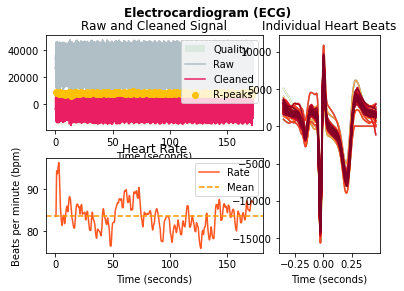

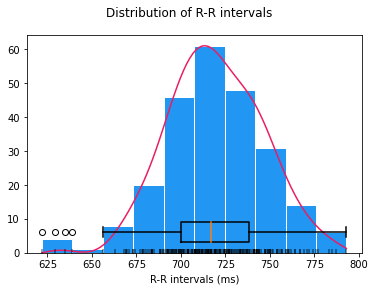

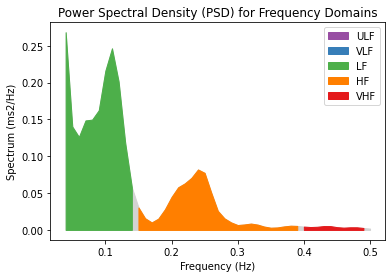

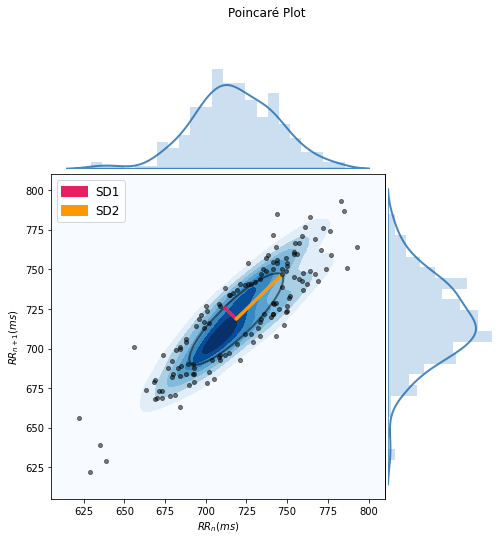

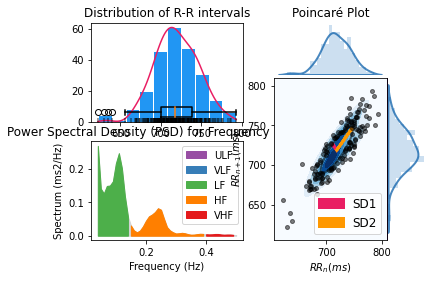

In [12]:
ecg_features, hrv_time, hrv_freq, hrv_non, hrv_all = get_ecg_features(bsp_features)

In [13]:
hrv_all

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSE,HRV_CMSE,HRV_RCMSE,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,718.740586,28.653531,4.727296,28.260727,NaN,NaN,NaN,NaN,13.97161,13.99914,...,1.322848,6.431909,0.940121,0.761792,1.407869,1.829119,1.272954,1.753871,2.061554,0.760334


In [14]:
# To extract relevant HRV Features, following techniques can be used:
# 1. Pearson's Correlation
# 2. Recursive Feature Elimination (RFE)
# 3. Extra Tree Classifier

hrv_all.columns

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2',
       'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD',
       'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
       'HRV_IQRNN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF',
       'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_LFHF', 'HRV_LFn',
       'HRV_HFn', 'HRV_LnHF', 'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2', 'HRV_S',
       'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_PIP', 'HRV_IALS',
       'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_SI', 'HRV_AI', 'HRV_PI', 'HRV_C1d',
       'HRV_C1a', 'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d', 'HRV_C2a', 'HRV_SD2d',
       'HRV_SD2a', 'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd', 'HRV_SDNNa',
       'HRV_DFA_alpha1', 'HRV_DFA_alpha1_ExpRange', 'HRV_DFA_alpha1_ExpMean',
       'HRV_DFA_alpha1_DimRange', 'HRV_DFA_alpha1_DimMean', 'HRV_DFA_alpha2',
       'HRV_DFA_alpha2_ExpRange', 'HRV_DFA_alpha2_ExpMean',
       'HRV_DFA_alpha2_DimRange', 'HRV_DFA

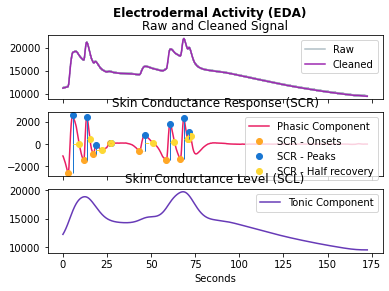

,EDA_Raw,EDA_Clean,EDA_Tonic,EDA_Phasic
0,11219.0,11208.472480,12276.476076,-1068.003594
1,11222.0,11208.905855,12276.978443,-1068.072587
2,11229.0,11209.338799,12277.480929,-1068.142128
3,11228.0,11209.771253,12277.983531,-1068.212276
4,11258.0,11210.203156,12278.486251,-1068.283093
...,...,...,...,...
172516,9413.0,9442.931768,9573.209965,-0.363689
172517,9444.0,9442.931770,9573.209964,-0.335711
172518,9422.0,9442.931771,9573.209964,-0.307733
172519,9471.0,9442.931772,9573.209964,-0.279755


In [15]:
get_eda_features(bsp_features)

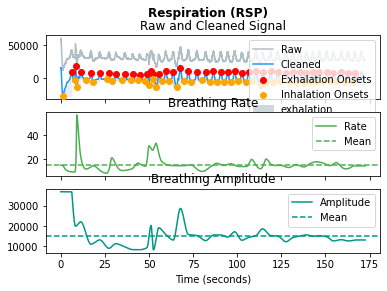

,RSP_Raw,RSP_Clean,RSP_Amplitude,RSP_Rate
0,59604.0,15927.490578,36809.343773,14.613474
1,59613.0,15937.083669,36809.343773,14.613474
2,59615.0,15946.622531,36809.343773,14.613474
3,59751.0,15956.103877,36809.343773,14.613474
4,59751.0,15965.524395,36809.343773,14.613474
...,...,...,...,...
172516,27303.0,-0.448969,13096.467449,14.124294
172517,27269.0,-0.387875,13096.467449,14.124294
172518,27271.0,-0.331988,13096.467449,14.124294
172519,27357.0,-0.281191,13096.467449,14.124294


In [16]:
get_rsp_features(bsp_features)

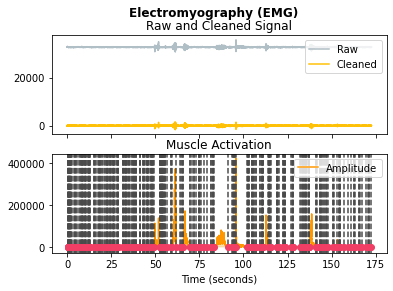

,EMG_Raw,EMG_Clean,EMG_Amplitude,EMG_Activity
0,32789.0,1.395254,2473.562715,0.0
1,32757.0,-32.722172,2500.422262,0.0
2,32722.0,-70.589464,2526.192188,0.0
3,32912.0,115.810212,2550.760752,0.0
4,32743.0,-57.231064,2574.049075,0.0
...,...,...,...,...
172516,32790.0,23.947700,4823.896005,0.0
172517,32788.0,27.579171,4805.397911,0.0
172518,32708.0,-40.561553,4788.909502,0.0
172519,32796.0,65.197885,4774.427309,0.0


In [17]:
get_emg_features(bsp_features)